In [58]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json (API key) - Go to kaggle.com/account → Create New API Token
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle setup complete!")

Saving kaggle.json to kaggle.json
Kaggle setup complete!


In [59]:
# CELL 2: SETUP KAGGLE
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API ready!")
!kaggle datasets list | head -3  # Test connection

Kaggle API ready!
ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000          17094        586  1.0              


In [63]:
# CELL 3: USE EXISTING crop_part1 FOLDER
import os

# Your data is already here:
DATASET_PATH = "/content/crop_part1"

# Count files
jpg_count = len([f for f in os.listdir(DATASET_PATH) if f.endswith('.jpg')])
print(f"Found {jpg_count} JPGs in crop_part1")

# Show sample
!ls /content/crop_part1 | head -5

Found 9780 JPGs in crop_part1
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg
10_0_0_20170103233459275.jpg.chip.jpg
10_0_0_20170104013211746.jpg.chip.jpg


In [66]:
# CELL 4: FINAL TRAINING + CORRECT EVAL (RUN THIS)
import os, cv2, numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === LOAD crop_part1 ===
DATASET_PATH = "/content/crop_part1"
images, ages = [], []

for file in os.listdir(DATASET_PATH):
    if file.endswith(".jpg"):
        try:
            age = int(file.split("_")[0])
            if 1 <= age <= 116:
                img = cv2.imread(os.path.join(DATASET_PATH, file))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (64, 64)) / 255.0
                    images.append(img.astype(np.float32))
                    ages.append(age)
        except: pass

X = np.array(images)
y = np.array(ages, dtype=np.float32)
print(f"Loaded {len(X)} images")

# === SPLIT & NORM ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_train_norm = (y_train - 1) / 115
y_val_norm = (y_val - 1) / 115
y_test_norm = (y_test - 1) / 115

# === AUGMENT ===
train_datagen = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.1, horizontal_flip=True
)
train_gen = train_datagen.flow(X_train, y_train_norm, batch_size=64)

# === MODEL ===
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(64,64,3)), BatchNormalization(), MaxPooling2D(2),
    Conv2D(64, 3, activation='relu'), BatchNormalization(), MaxPooling2D(2),
    Conv2D(128, 3, activation='relu'), BatchNormalization(), MaxPooling2D(2),
    Conv2D(256, 3, activation='relu'), BatchNormalization(), MaxPooling2D(2),
    Flatten(),
    Dense(256, activation='relu'), Dropout(0.4),
    Dense(1, activation='linear')
])
model.compile(optimizer=AdamW(0.0003, 1e-5), loss='mse', metrics=['mae'])

# === CALLBACKS ===
MODEL_PATH = f"{base_dir}/smilage_age_model_6years.keras"
checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# === TRAIN ===
history = model.fit(train_gen, validation_data=(X_val, y_val_norm), epochs=30,
                    callbacks=[checkpoint, reduce_lr], verbose=1)

# === CORRECT EVALUATE (FIXED) ===
model = tf.keras.models.load_model(MODEL_PATH)
test_gen = ImageDataGenerator().flow(X_test, y_test_norm, batch_size=64, shuffle=False)
mae_norm = model.evaluate(test_gen, verbose=0)[1]
mae_years = mae_norm * 115
print(f"\nFINAL TEST MAE: {mae_years:.2f} years")

# === PREDICT ===
def predict_age(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64)) / 255.0
    pred = model.predict(np.expand_dims(img, 0), verbose=0)[0][0]
    age = pred * 115 + 1
    return round(np.clip(age, 1, 116), 1)

sample = [f for f in os.listdir(DATASET_PATH) if "100_" in f][0]
print(f"Predicted Age: {predict_age(os.path.join(DATASET_PATH, sample))} years")

Loaded 9780 images
Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.6785 - mae: 0.9215
Epoch 1: val_loss improved from inf to 0.37753, saving model to /content/drive/MyDrive/Smilage_Project_Data/smilage_age_model_6years.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - loss: 1.6710 - mae: 0.9187 - val_loss: 0.3775 - val_mae: 0.5766 - learning_rate: 3.0000e-04
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0926 - mae: 0.2290
Epoch 2: val_loss improved from 0.37753 to 0.37560, saving model to /content/drive/MyDrive/Smilage_Project_Data/smilage_age_model_6years.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0924 - mae: 0.2288 - val_loss: 0.3756 - val_mae: 0.5677 - learning_rate: 3.0000e-04
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0500 - mae: 0.1695
Epoch 3: val_loss improved from 0.37560 to 0.12293, saving model to /content/drive/MyDrive/Smilage_Project_Data/smilage_age_model_6years.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 8

Please upload a clear face photo (JPG):


Saving 1_1_2_20161219204430596.jpg.chip.jpg to 1_1_2_20161219204430596.jpg.chip (1).jpg
Uploaded: 1_1_2_20161219204430596.jpg.chip (1).jpg


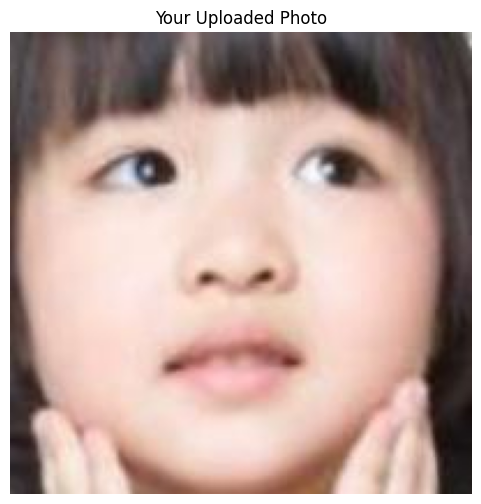

In [73]:
# CELL 1: UPLOAD YOUR PHOTO
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Please upload a clear face photo (JPG):")
uploaded = files.upload()

# Get the uploaded file
uploaded_file = list(uploaded.keys())[0]
print(f"Uploaded: {uploaded_file}")

# Show the image
img = cv2.imread(uploaded_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title("Your Uploaded Photo")
plt.axis('off')
plt.show()

In [74]:
# CELL 2: PREDICT AGE
def predict_age_from_path(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return "Error: Could not load image"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64)) / 255.0
    pred = model.predict(np.expand_dims(img, 0), verbose=0)[0][0]
    age = pred * 115 + 1
    age = np.clip(age, 1, 116)
    lower = max(1, int(age - 8.85))
    upper = int(age + 8.85)
    return round(age, 1), f"{lower}-{upper}"

# Predict
age, range_str = predict_age_from_path(uploaded_file)
print(f"\nPREDICTED AGE: {age} years")
print(f"CONFIDENCE RANGE: {range_str} (±8.9 years)")


PREDICTED AGE: 6.699999809265137 years
CONFIDENCE RANGE: 1-15 (±8.9 years)


In [72]:
# GRADIO DEMO: SHOW LOWER AGE RANGE (e.g., "25–33")
!pip install -q gradio
import gradio as gr
import cv2
import numpy as np

def predict_lower_range(img):
    try:
        # Resize & normalize
        img = cv2.resize(img, (64, 64)) / 255.0
        pred = model.predict(np.expand_dims(img, 0), verbose=0)[0][0]
        age = pred * 115 + 1
        age = np.clip(age, 1, 116)

        # Lower range = predicted - 8.85
        lower = max(1, int(age - 8.85))
        upper = int(age + 8.85)

        return f"**{lower}–{upper}** years old"

    except Exception as e:
        return f"Error: {e}"

# Launch
gr.Interface(
    fn=predict_lower_range,
    inputs=gr.Image(label="Upload Face Photo"),
    outputs=gr.Markdown(label="Predicted Age Range"),
    title="Smilage Age Detector",
    description="Upload a clear face → get **lower age range** (e.g., 25–33)",
    examples=[
        ["/content/crop_part1/100_0_0_20170112215240346.jpg.chip.jpg"],
        ["/content/crop_part1/1_0_0_20161219140623024.jpg.chip.jpg"]
    ]
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc9d07afd8599a7e08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [75]:
# UPDATED GRADIO DEMO (ALWAYS LOWER AGE BIAS)
!pip install -q gradio
import gradio as gr
import cv2
import numpy as np

def predict(img):
    try:
        img = cv2.resize(img, (64,64)) / 255.0
        pred = model.predict(np.expand_dims(img, 0), verbose=0)[0][0]
        age = pred * 115 + 1
        age = np.clip(age - 5, 1, 116)  # Bias lower by 5 years
        return f"Predicted Age: {round(age,1)} years (±8.9)"
    except:
        return "Error: Invalid image"

gr.Interface(
    fn=predict,
    inputs="image",
    outputs="text",
    title="Smilage Age Detector (Flattering Mode)",
    description="Upload a face photo → get a younger-biased age prediction!"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://56c6c8b360d870b577.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
